# Numerische Integration

## Vertiefung

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


### Übersicht


1. Trapezformel vektorisiert implementieren
2. Fehlerabschätzung
3. Trapezformel für Daten mit ungleichmässigem Abstand
4. SciPy-Integration

### 1. Trapezformel vektorisiert implementieren

Vorgehen beim Integrieren mit der [Trapezregel](https://de.wikipedia.org/wiki/Trapezregel):

- Zerlege das Intervall $[a,b]$ in $n$ gleich breite Intervalle.
- Berechne Funktionswerte an den Intervallgrenzen und verbinde diese mit Geraden, so dass $n-1$ Trapeze entstehen.
- Berechne die Flächen der Trapeze.
- Die Summe aller Flächen ergibt eine Näherung des Integrals.
- Je größer $n$ desto genauer das Ergebnis.

$$ T_n = \frac{h}{2} \left( f(a) + 2\sum_{i=1}^{n-1} f(a + ih) + f(b) \right) \,,\qquad\text{wobei}\quad h = \frac{b-a}{n} $$

In [2]:
def trapz_comprehension(func, a, b, n):
    h = (b - a) / n
    s = sum(func(a + i * h) for i in range(1, n))
    return 0.5 * h * (func(a) + 2 * s + func(b))


In [3]:
def trapz_vectorized(func, a, b, n):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = func(x)
    return 0.5 * h * (y[0] + 2 * np.sum(y[1:-1]) + y[-1])


Test mit der Funktion

$$ f(x) = \sin(x) $$

[Analytisches Resultat](https://www.wolframalpha.com/input?i=int+sin%28x%29+from+0+to+pi):

$$ \int_0^{\pi} \sin(x) \,dx = 2 $$

Numerische Näherung ausrechnen und visualisieren.

In [4]:
n = 1000
T1 = trapz_comprehension(np.sin, 0, np.pi, n)
T2 = trapz_vectorized(np.sin, 0, np.pi, n)
print((T1, T2, T1 - T2))
print((T1 - 2, T2 - 2))


(1.9999983550656624, 1.9999983550656624, 0.0)
(-1.6449343376301329e-06, -1.6449343376301329e-06)


In [5]:
%timeit trapz_comprehension(np.sin, 0, np.pi, n)
%timeit trapz_vectorized(np.sin, 0, np.pi, n)

920 µs ± 88.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
52.4 µs ± 5.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 2. Fehlerabschätzung


#### Explorativ

Abhängigkeit des Fehlers von $n$. Beispiel von oben.

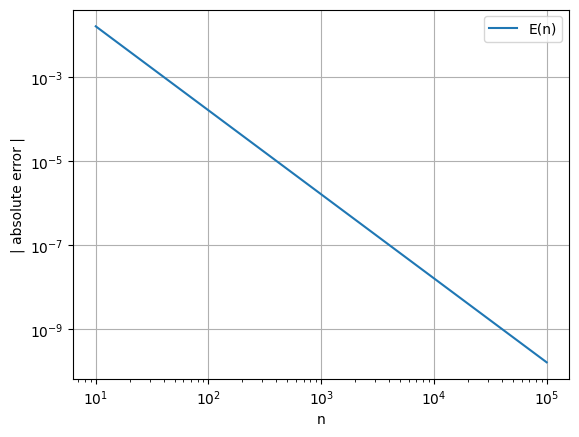

In [6]:
ns = np.logspace(1, 5, dtype=int)
# ns = [10, 100, 1000, 10000, 100000]
errors = np.array([abs(trapz_vectorized(np.sin, 0, np.pi, n) - 2) for n in ns])

plt.loglog(ns, errors, label="E(n)")
plt.xlabel("n")
plt.ylabel("| absolute error |")
plt.grid()
plt.legend()
plt.show()


Der Fehler $E(n)$ ist eine Gerade im Log-Log-Plot. Das heisst, es handelt sich um eine Potenzfunktion

$$ E(n) = C \cdot n^p $$

und $p$ ist die Steigung der Geraden im Log-Log-Plot. Berechnen wir also mal die Steigung zwischen je zwei Punkten und mitteln diese:

In [7]:
np.mean(np.diff(np.log10(errors)) / np.diff(np.log10(ns)))


-2.000184977387091

#### Trapezregel Abschätzung

Eine analytische [Fehlerabschätzung ist in Wikipedia](https://de.wikipedia.org/wiki/Trapezregel#Fehlerabsch%C3%A4tzung) zu finden. Der Fehler

$$ E_n = \int_a^b (x) \,dx - T_n $$

ist beschränkt durch

$$ \left| E_n \right| \leq \frac{(b-a)}{12}\cdot h^2 M_2 = \frac{(b-a)^3}{12} \cdot n^{-2} M_2 $$

wobei

$$ M_2 = \max_{a \leq x \leq b} \left| f''(x) \right| $$

Das heisst, der Fehler ist proportional zu $h^2$ bzw. $n^{-2}$, wie wir oben bereits gesehen haben.

Zudem ist der Fehler auch proportional zum Maximum der zweiten Ableitung der Funktion, $M_2$. Das heisst, je stärker die Funktion im Intervall $[a,b]$ schwankt (grössere Krümmung), desto grösser ist der Fehler durch die Näherung mit der Trapezregel.

Videos:

- [Fehler der Trapezregel für numerische Integration - Jörn Loviscach](https://youtu.be/JwPlWzP-K1A)
- [Analysis Numerische Integration: Trapezformel Abschätzung des Fehlers (Trapezregel) - Henning Dierks](https://youtu.be/PifHwEaUxoo)


### 3. Trapezformel für Daten mit ungleichmässigem Abstand

#### Beispiel-Daten erzeugen

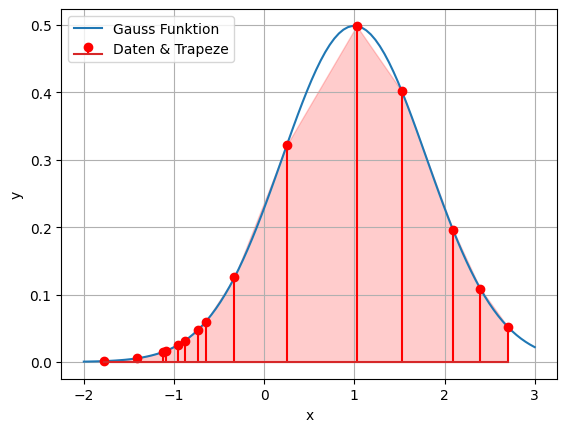

In [8]:
def gauss(x, mu=0, sigma=1):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))


mu = 1
sigma = 0.8
x = np.linspace(-2, 3, 100)
y = gauss(x, mu, sigma)

n_samples = 15
rng = np.random.default_rng(8888)
x_samples = np.sort(rng.uniform(low=x.min(), high=x.max(), size=n_samples))
y_samples = gauss(x_samples, mu, sigma)

plt.plot(x, y, label="Gauss Funktion")
plt.stem(x_samples, y_samples, "r", label="Daten & Trapeze")
plt.fill_between(x_samples, y_samples, 0, alpha=0.2, color="r")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()


#### Trapezformel für Daten

Die Trapezformel für Daten mit ungleichmässigem Abstand $(x_i, y_i)$ mit $i=0,\ldots,n$ lautet:

$$ T_n = \frac{1}{2} \sum_{k=1}^{n} \left( x_{k} - x_{k-1} \right) \left( y_{k} + y_{k-1} \right) $$

Hier ist

- $\Delta x_k = x_{k} - x_{k-1}$ die Breite des $k$-ten Trapezes und
- $\frac{1}{2} \left( y_{k} + y_{k-1} \right)$ die mittlere Höhe des $k$-ten Trapezes.

Mehr dazu in diesem Video:

- [Analysis Numerische Integration: Trapezformel #13-55 - Henning Dierks](https://youtu.be/8i6KtWTec6c)

#### Implementation als Comprehension

``x[k] - x[k-1]`` schreibe wir wir die **Distanz berechnen wollen!**


``y[k] + y[k - 1]`` schreiben wir weil wir den **Mittelwert berechnen wollen**

In [9]:
def trapz_data_comprehension(x, y):
    return 0.5 * sum((x[k] - x[k - 1]) * (y[k] + y[k - 1]) for k in range(1, len(x)))


trapz_data_comprehension(x_samples, y_samples)


0.9624549013464068

#### Vektorisierte Implementation

In [10]:
def trapz_data_vectorized(x, y):
    return 0.5 * np.sum((x[1:] - x[:-1]) * (y[1:] + y[:-1]))


trapz_data_vectorized(x_samples, y_samples)


0.9624549013464068

In [17]:
%timeit trapz_data_comprehension(x_samples, y_samples)
%timeit trapz_data_vectorized(x_samples, y_samples)

9.92 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.81 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### 4. SciPy-Integration

- Übersichtsseite: [SciPy-Integration](https://docs.scipy.org/doc/scipy/tutorial/integrate.html)
- Integration von Funktionen mit [`scipy.integrate.quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)
- Integration von Daten mit [`scipy.integrate.trapezoid`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html)

In [12]:
scipy.integrate.quad(np.sin, 0, np.pi)


(2.0, 2.220446049250313e-14)

In [13]:
scipy.integrate.quad(np.sin, 0, np.pi)[0] - trapz_vectorized(np.sin, 0, np.pi, 1000)


1.6449343376301329e-06

Beispiel mit Daten:

In [14]:
scipy.integrate.trapezoid(y_samples, x_samples)


0.9624549013464068

In [15]:
scipy.integrate.trapezoid(y_samples, x_samples) - trapz_data_vectorized(x_samples, y_samples)


0.0

In [19]:
%timeit scipy.integrate.trapezoid(y_samples, x_samples)
%timeit trapz_data_vectorized(x_samples, y_samples)

17.2 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.71 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
